*Licensed under the MIT License. See LICENSE-CODE in the repository root for details.*

*Copyright (c) 2025 Eleni Kamateri*

This script plots the number of single patents per section label (IPCR and CPC). It uses a CSV file containing essential data for analyzing patent documents within a specific core vertical (e.g., EP). 

### Set the required parameters for the script

In [1]:
csv_file_path='/YOUR_PATH/EP_csv_file_for_wpi_analysis.csv'
sep=0
classification_selection=1

### Import all required libraries for the script

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer

### Import the CSV file and load its data into a DataFrame

In [3]:
if sep==0:
    DF = pd.read_csv(csv_file_path, header=0, delimiter=";") #, nrows=1000)
elif sep==1:
    DF = pd.read_csv(csv_file_path, header=0) #, nrows=1000)
else:
    print("Please provide a valid value for sep")

print(DF.shape)
DF.head(1)

(552439, 11)


,Unnamed: 0,xml_file_name,ucid,date,main_classification,further_classification,classification_ipcr,classification_cpc,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist
0,0,EP-2677851-A1.xml,EP-2677851-A1,20140101,NaN,NaN,A01B 79/02 20060101AFI20120911BHEP ...,A01B 79/005 20130101 LI20150420BHEP ...,1.0,1.0,1.0


### Identify the patent number and kind code, and append these fields to the initial DataFrame

In [4]:
DF['patent_number']=DF['xml_file_name'].str.split(".").str[0]
DF['patent_number']=DF['patent_number'].str.split("-").str[1:2]
DF['patent_number']=DF['patent_number'].str.join('')

DF['kind_code']=DF['xml_file_name'].str.split(".").str[0]
DF['kind_code']=DF['kind_code'].str.split("-").str[2:3]
DF['kind_code']=DF['kind_code'].str.join('')

DF['kind_code_letter']=DF['kind_code'].str[0]

### Remove unnecessary columns
Since we are creating classification test sets for IPCR labels, we delete the columns containing IPC and CPC labels.

In [5]:
if classification_selection==0:
    DF['labels']=DF['main_classification'] + ", " + DF['further_classification']
    if 'classification_ipcr' in df.columns:
        del DF['classification_ipcr']
    if 'classification_cpc' in df.columns:
        del DF['classification_cpc']     
elif classification_selection==1:
    DF=DF.rename(columns={'classification_ipcr': 'labels'})
    if 'main_classification' in DF.columns:
        del DF['main_classification']
    if 'further_classification' in DF.columns:
        del DF['further_classification']
    if 'classification_cpc' in DF.columns:
        del DF['classification_cpc'] 
elif classification_selection==2:
    DF=DF.rename(columns={'classification_cpc': 'labels'})
    if 'main_classification' in DF.columns:
        del DF['main_classification']
    if 'further_classification' in DF.columns:
        del DF['further_classification']
    if 'classification_ipcr' in DF.columns:
        del DF['classification_ipcr'] 
else:
    print("Please provide a valid value for classification_selection")

cols_to_replace = ['abstract_lang_en_exist', 'description_lang_en_exist', 'claims_lang_en_exist']
DF[cols_to_replace] = DF[cols_to_replace].astype(int)

DF.head(1)

,Unnamed: 0,xml_file_name,ucid,date,labels,abstract_lang_en_exist,description_lang_en_exist,claims_lang_en_exist,patent_number,kind_code,kind_code_letter
0,0,EP-2677851-A1.xml,EP-2677851-A1,20140101,A01B 79/02 20060101AFI20120911BHEP ...,1,1,1,2677851,A1,A


# Analysis of labels

### Keep the latest kind code for each patent

Since all kind codes of the same patent include classification labels, we keep their latest version. This ensures that we work with the most up-to-date classification labels assigned to the most recent kind code of each patent.

In [6]:
DF_=DF.copy()
DF_['labels']=DF_['labels'].fillna("")
DF_=DF_[DF_['labels']!='']
DF_=DF_.sort_values(by = 'xml_file_name', ascending=True)
DF_ = DF_.drop_duplicates(subset = ["patent_number"])
DF_.shape

(469757, 11)

### Example of Label Processing

In [7]:
xx='G01N  33/53        20060101ALI20040803BHEP    '
xx=xx.strip()
xx=xx.rsplit('/')[0]
xx=xx.replace(" ", "")
xx=xx.strip()
xx

'G01N33'

### Find the group labels and their frequencies

In [8]:
# Split the 'labels' column by commas
DF_['labels'] = DF_['labels'].str.split(',')

# Extract the first part of each label after splitting by '/'
DF_['labels'] = DF_['labels'].apply(lambda x: [item.split('/')[0] for item in x])
DF_['labels'] = DF_['labels'].apply(lambda x: [item.replace(" ", "") for item in x])

expanded_DF=DF_['labels'].apply(pd.Series)

# Transform 'na' values of the expanded table into empty content cells
expanded_DF=expanded_DF.fillna("")

# Infer the group label (delete the last I/N character and  empty spaces from the beginning/end - if any)
nums=expanded_DF.shape[1]
for num in range (nums):
    expanded_DF[num]=expanded_DF[num].str.strip()

# Create a new table with group labels and their frequencies
total_counter = Counter()

for num in range(nums):
    exec(f'counter_{num} = Counter(expanded_DF[num])')
    exec(f'total_counter=total_counter+counter_{num}')

code_, freq_ = [], []

for code, freq in total_counter.items():
    code_.append(code)
    freq_.append(freq)

DF_codes = pd.DataFrame()
DF_codes['code'] = code_
DF_codes['freq'] = freq_

# Delete empty rows
DF_codes=DF_codes[DF_codes['code']!='']

# Sort based on freq
DF_codes=DF_codes.sort_values(by = 'freq', ascending=True)

print(DF_codes.shape, DF_codes['freq'].sum())
DF_codes

(7163, 2) 1618015


,code,freq
7163,B29K73,1
6575,F22D7,1
6570,G05B24,1
6569,C25B7,1
5363,F16M9,1
...,...,...
10,A61K8,13155
112,H04N21,13724
14,G06F3,15448
109,H04L12,16618


### Find the subclass labels and their frequencies

In [9]:
DF_subclass=DF_codes.copy()
DF_subclass['code_subclass']= None
DF_subclass=DF_subclass.reset_index(drop=True)
for i in range (DF_subclass['code'].shape[0]):
    DF_subclass.loc[i, 'code_subclass']=DF_subclass['code'][i][0:4]
DF_subclass['freq_subclass'] = DF_subclass.groupby('code_subclass')['freq'].transform('sum')
DF_subclass = DF_subclass.drop_duplicates(subset = ["code_subclass"])
DF_subclass=DF_subclass.sort_values(by = 'freq_subclass', ascending=True)
DF_subclass=DF_subclass.reset_index(drop=True)

print(DF_subclass.shape, DF_subclass['freq_subclass'].sum())
DF_subclass

(632, 4) 1618015


,code,freq,code_subclass,freq_subclass
0,B62C1,1,B62C,1
1,F24T10,1,F24T,1
2,C06F3,1,C06F,1
3,G09D3,2,G09D,2
4,B41B11,1,B41B,2
...,...,...,...,...
627,H04N20060101SI20070224RMEP,1,H04N,44094
628,H04L21,1,H04L,46569
629,H04W99,21,H04W,48527
630,G06F20060101AFI20130516BHEP,1,G06F,50155


### Plot the distribution of patents per section label

(8, 6) 1618015


No handles with labels found to put in legend.


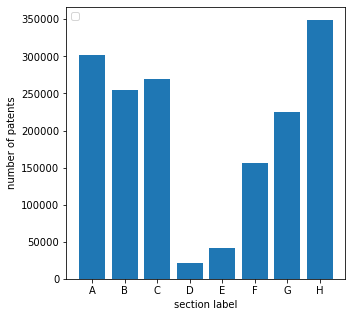

In [11]:
# Prepare the plot: labels_section vs number_patents
DF_plot1_c=DF_subclass.copy()
DF_plot1_c['code_section']= None
DF_plot1_c=DF_plot1_c.reset_index(drop=True)
for i in range (DF_plot1_c['code'].shape[0]):
    DF_plot1_c.loc[i, 'code_section']=DF_plot1_c['code'][i][0:1]
DF_plot1_c['freq_section'] = DF_plot1_c.groupby('code_section')['freq_subclass'].transform('sum')
DF_plot1_c = DF_plot1_c.drop_duplicates(subset = ["code_section"])
DF_plot1_c=DF_plot1_c.sort_values(by = 'code_section', ascending=True)
DF_plot1_c=DF_plot1_c.reset_index(drop=True)

print(DF_plot1_c.shape, DF_plot1_c['freq_section'].sum())

x = DF_plot1_c['code_section']
y = DF_plot1_c['freq_section']

fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches

plt.bar(x,y)#,label="")

plt.xlabel("section label")
plt.ylabel("number of patents")
plt.title("")
plt.legend()
plt.show()